## Optuna (IonQ)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import optuna
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA

from shared.graph_helper import *
from shared.QiskitMaxcut import *
from ionq.ionq_parameters import *

%matplotlib inline

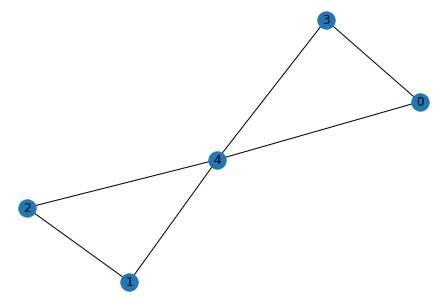

In [3]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
#graph = load_nx_graph_from("../data/graphs/04_nodes/graph_04_04_03_w.txt")
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()


In [4]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=simulator_backend,
                    shots=SHOTS)

    qaoa = QAOA(optimizer=optimizer, quantum_instance=quantum_instance, reps=reps, 
               initial_point=init_parameters) 
    
    return qaoa

In [5]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(max_cut_problem)
    optimal_parameters = qaoa.optimal_params
    
    return result, optimal_parameters.copy()

In [6]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX + 1)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]

    qaoa = init_qaoa(optimizer, reps, parameters)

    result, optimal_parameters = run(max_cut_qubo, qaoa)
    mean, distribution = max_cut.analyse(result)

    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters])

    return mean

In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-30 16:01:25,756] A new study created in memory with name: no-name-167472c3-61b5-4b22-b3b6-6e40dd1d3ba9
/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/qiskit_ionq/ionq_backend.py:290: UserWarning: Option max_credits is not used by this backend
  return super().run(circuit, **kwargs)
[I 2021-07-30 16:06:45,548] Trial 0 finished with value: -25.04599999999999 and parameters: {'optimizer': 'SPSA', 'reps': 9, 'gamma_0': -2.9442604448688847, 'gamma_1': 2.677537938635326, 'gamma_2': 0.007886363064078417, 'gamma_3': 1.246953215747098, 'gamma_4': 1.9829489470413373, 'gamma_5': 2.3844950399855396, 'gamma_6': 0.9398778512376422, 'gamma_7': -2.5519083153939444, 'gamma_8': 2.5997610362813335, 'beta_0': 0.9266217145242921, 'beta_1': -1.389916690597686, 'beta_2': 1.288785568638696, 'beta_3': -2.506236049764976, 'beta_4': 0.12960975758241355, 'beta_5': 0.4610907430315301, 'beta_6': 0.4924700897079983, 'beta_7': 2.3280823366613737, 'beta_8': -1.2502472552301949}. Best 

ReadTimeout: HTTPSConnectionPool(host='api.ionq.co', port=443): Read timed out. (read timeout=None)

In [ ]:
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params = study.user_attrs["best"]
optimal_params

In [ ]:
max_cut.draw(result)

In [ ]:
mean, distribution = max_cut.analyse(result, print_output=True)
plot_histogram(distribution, color='midnightblue', title=f"Expectation Value (Ø: {mean:.3f})")

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table